In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

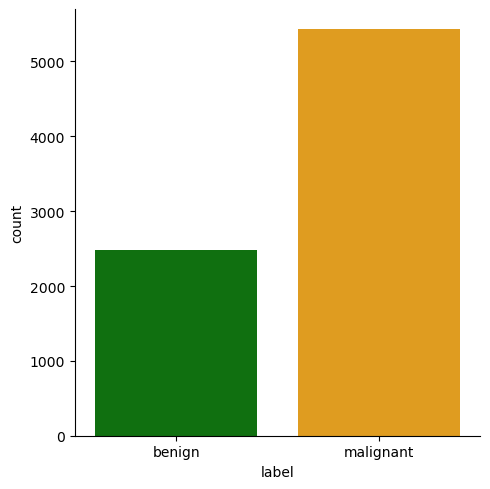

In [3]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = folds.iloc[:7909].copy()
df["label"] = df["filename"].apply(lambda x: x.split("/")[3]).str.strip()
sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
plt.show()
df['label_int'] = df['label'].apply(lambda x: ['benign', 'malignant'].index(x))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [7]:
def parse_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [224, 224]) / 255.0  # ResNet50 expects 224x224 input size
    return img, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [9]:
train_filenames = "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train
test_filenames = "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test

In [11]:
train_loader = tf.data.Dataset.from_tensor_slices((train_filenames, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((test_filenames, y_test))

In [13]:
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-07-26 21:53:36.606647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3182 of 6327
2024-07-26 21:53:46.943188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-26 21:53:47.189134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


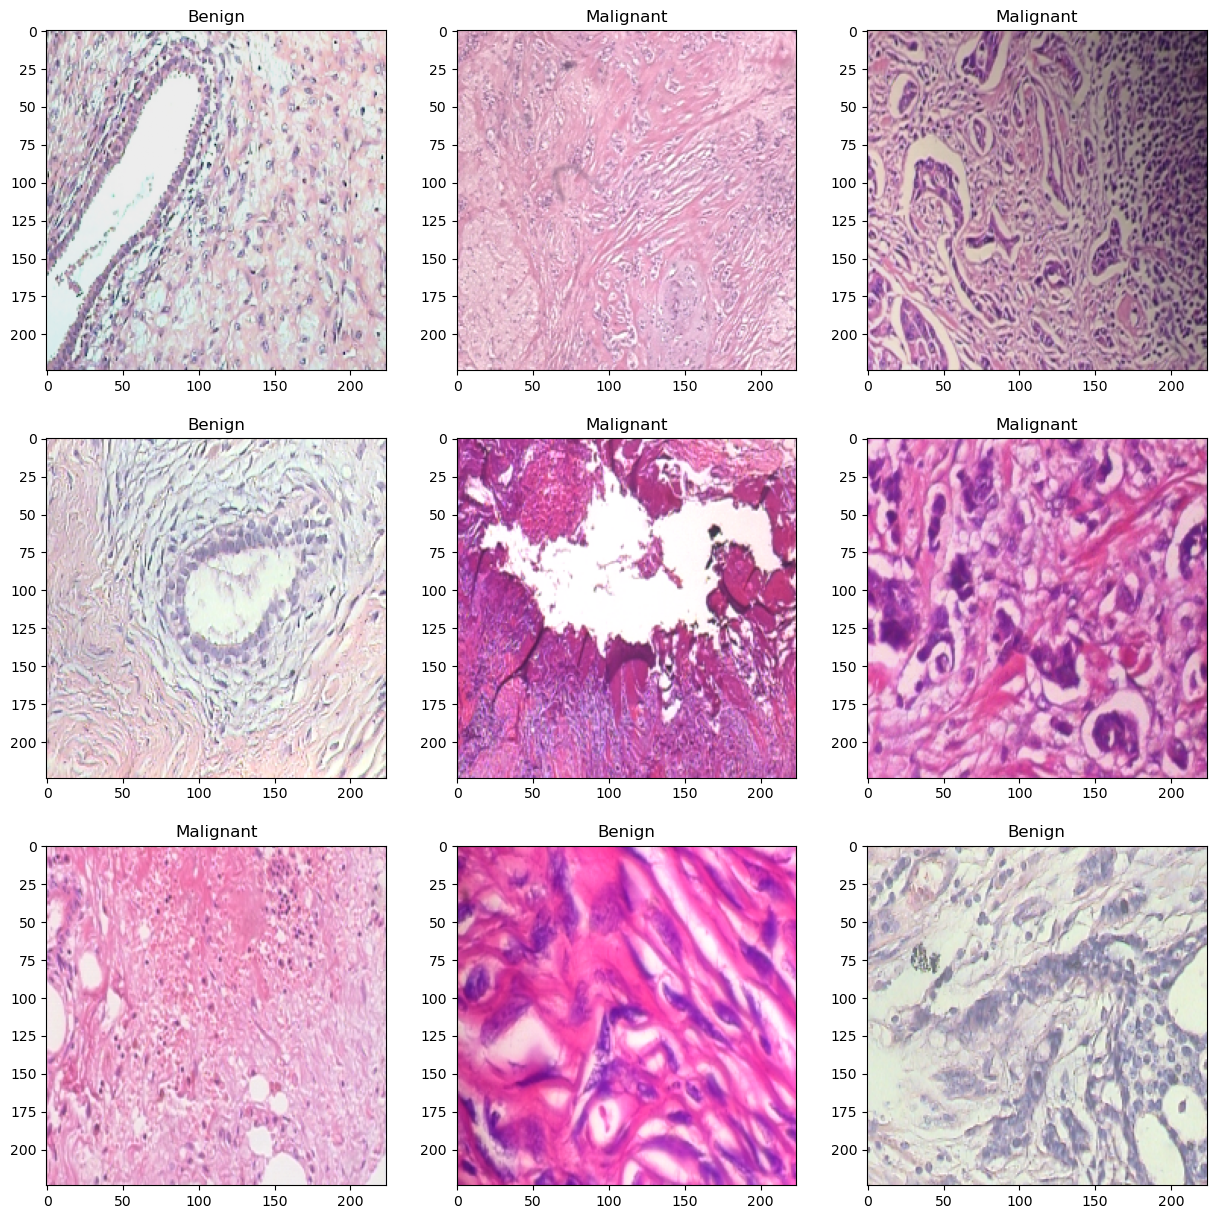

In [15]:
fig = plt.figure(figsize=(15, 15))
for images, labels in X_trainset.take(1):
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1)
        ax.set_title("Benign" if labels.numpy()[i] == 0 else "Malignant")
        plt.imshow(images.numpy()[i])
plt.show()

In [17]:
input_shape = (224, 224, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False 

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(2, activation="softmax")
])


In [19]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,723,138 (90.50 MB)

 Trainable params: 135,426 (529.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('The Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

In [23]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [25]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

Epoch 1/25


2024-07-26 21:56:45.678879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3069 of 6327
2024-07-26 21:56:56.611853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.5333 - loss: 0.7411 - val_accuracy: 0.6144 - val_loss: 0.6630
Epoch 2/25


2024-07-26 22:02:45.728508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 1612 of 6327
2024-07-26 22:02:55.730048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3251 of 6327
2024-07-26 22:03:05.730398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 4863 of 6327
2024-07-26 22:03:14.662141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.5327 - loss: 0.6862 - val_accuracy: 0.6732 - val_loss: 0.6445
Epoch 3/25


2024-07-26 22:10:41.210767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 1564 of 6327
2024-07-26 22:11:01.218732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5457 of 6327
2024-07-26 22:11:04.878949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.5261 - loss: 0.6878 - val_accuracy: 0.4817 - val_loss: 0.6903
Epoch 4/25


2024-07-26 22:15:40.627921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2649 of 6327
2024-07-26 22:15:53.868323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.5174 - loss: 0.6825 - val_accuracy: 0.6903 - val_loss: 0.6259
Epoch 5/25


2024-07-26 22:20:19.006938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2597 of 6327
2024-07-26 22:20:33.364650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.5526 - loss: 0.6925 - val_accuracy: 0.4001 - val_loss: 0.7193
Epoch 6/25


2024-07-26 22:25:13.687582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2612 of 6327
2024-07-26 22:25:27.969004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.5232 - loss: 0.6824 - val_accuracy: 0.4589 - val_loss: 0.7116
Epoch 7/25


2024-07-26 22:30:04.209091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2543 of 6327
2024-07-26 22:30:18.313425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.5279 - loss: 0.6780 - val_accuracy: 0.4482 - val_loss: 0.6916
Epoch 8/25


2024-07-26 22:35:01.564598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2627 of 6327
2024-07-26 22:35:15.202524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.5117 - loss: 0.6785 - val_accuracy: 0.6245 - val_loss: 0.6512
Epoch 9/25


2024-07-26 22:39:51.485736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2597 of 6327
2024-07-26 22:40:05.362788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.5532 - loss: 0.6745 - val_accuracy: 0.5417 - val_loss: 0.6764
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7050 - loss: 0.6197


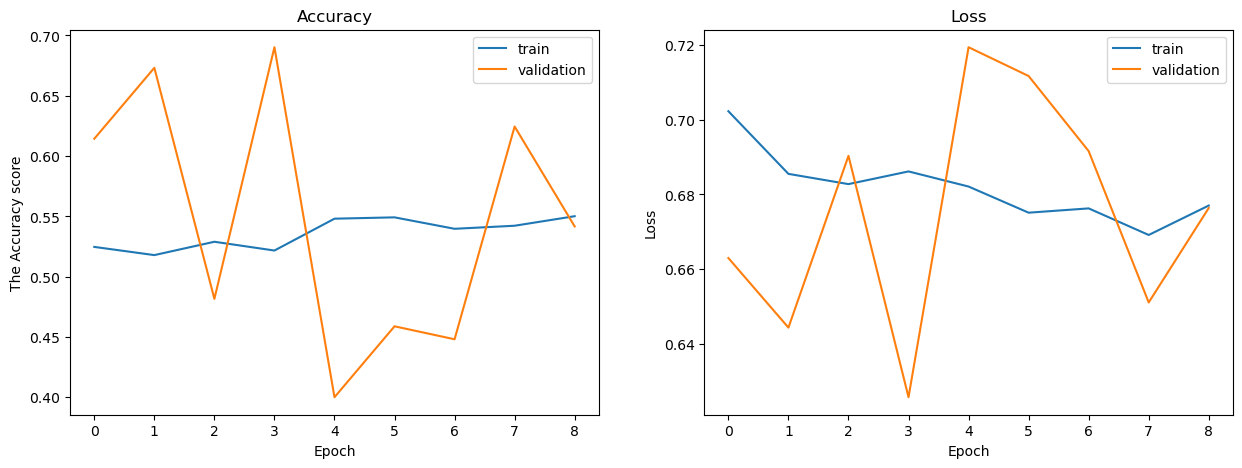

25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
              precision    recall  f1-score   support

      Benign       0.79      0.05      0.10       510
   Malignant       0.69      0.99      0.81      1072

    accuracy                           0.69      1582
   macro avg       0.74      0.52      0.46      1582
weighted avg       0.72      0.69      0.58      1582



2024-07-26 22:46:26.106793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))

<Axes: >

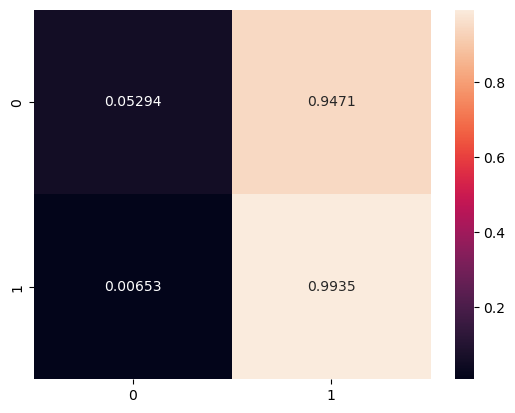

In [31]:
# The Confusion matrix
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

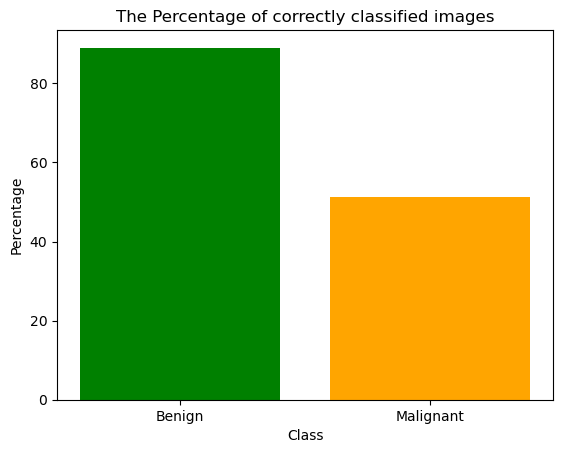

In [33]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)


25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


2024-07-26 23:26:39.248055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


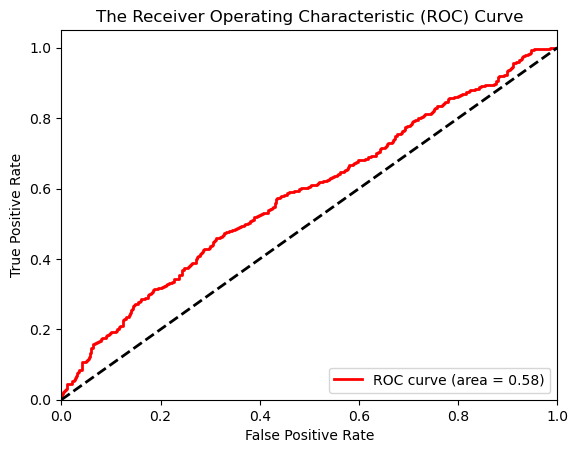

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_pred_prob = model.predict(X_testset)
true_categories = np.concatenate([y for x, y in X_testset])
y_test_pred_prob_class1 = y_test_pred_prob[:, 1]
fpr, tpr, _ = roc_curve(true_categories, y_test_pred_prob_class1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
